In [34]:
import math as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
import re
import itertools as it
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


In [35]:
dfBuildOwner = pd.read_csv('C:/Users/Asus/Documents/HackerEarth/Dataset/Building_Ownership_Use.csv')
dfBuildStructure = pd.read_csv('C:/Users/Asus/Documents/HackerEarth/Dataset/Building_Structure.csv')
dfTrain = pd.read_csv('C:/Users/Asus/Documents/HackerEarth/Dataset/train.csv')
print dfBuildOwner.shape
print dfBuildStructure.shape
print dfTrain.shape

(1052948, 17)
(1052948, 29)
(631761, 14)


In [36]:
dfTest = pd.read_csv('C:/Users/Asus/Documents/HackerEarth/Dataset/test.csv')
dfMergedTest = dfTest.merge(dfBuildStructure,on='building_id').merge(dfBuildOwner,on='building_id')
print dfMergedTest.shape

(421175, 57)


In [37]:
dfMergedTrain = dfTrain.merge(dfBuildStructure,on='building_id').merge(dfBuildOwner,on='building_id')
print dfMergedTrain.shape

(631761, 58)


In [39]:
dfMergedTrain.head(20)

,area_assesed,building_id,damage_grade,district_id_x,has_geotechnical_risk,has_geotechnical_risk_fault_crack,has_geotechnical_risk_flood,has_geotechnical_risk_land_settlement,has_geotechnical_risk_landslide,has_geotechnical_risk_liquefaction,has_geotechnical_risk_other,has_geotechnical_risk_rock_fall,has_repair_started,vdcmun_id_x,district_id_y,vdcmun_id_y,ward_id_x,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,district_id,vdcmun_id,ward_id_y,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,Both,24385bfd2a2,Grade 4,24,0.0,0,0,0,0,0,0,0,0.0,2489,24,2489,248903,3,3,21,385,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,0,0,0,0,0,0,0,0,0,0,Damaged-Not used,24,2489,248903,Private,2.0,0.0,0,0,0,0,0,0,0,0,0,0
1,Both,405d1bbebbf,Grade 2,44,0.0,0,0,0,0,0,0,0,1.0,4423,44,4423,442304,3,3,33,602,24,24,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,0,0,1,0,0,0,0,0,0,Damaged-Repaired and used,44,4423,442304,Private,1.0,1.0,0,1,0,0,0,0,0,0,0,0
2,Both,351d9bc71f6,Grade 1,36,0.0,0,0,0,0,0,0,0,0.0,3650,36,3650,365008,3,3,2,700,21,21,Steep slope,RC,RCC/RB/RBC,RC,RCC/RB/RBC,Attached-1 side,Rectangular,0,0,0,0,0,0,0,0,0,1,0,Not damaged,36,3650,365008,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
3,Building removed,2be3a971166,Grade 5,30,0.0,0,0,0,0,0,0,0,0.0,3016,30,3016,301605,3,0,3,315,20,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,30,3016,301605,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
4,Both,34c7d073ea6,Grade 3,36,0.0,0,0,0,0,0,0,0,0.0,3627,36,3627,362705,2,2,22,285,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Used in risk,36,3627,362705,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
5,Exterior,1f54965821f,Grade 5,21,0.0,0,0,0,0,0,0,0,0.0,2153,21,2153,215301,3,0,41,400,19,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble unclear,21,2153,215301,Private,0.0,0.0,0,0,0,0,0,0,0,0,0,0
6,Both,2beb42eaeee,Grade 2,30,1.0,0,0,0,1,0,0,1,0.0,3018,30,3018,301809,1,1,3,87,7,7,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Brick/Stone,Not applicable,Not attached,Rectangular,0,0,0,0,0,0,1,1,0,0,0,Damaged-Used in risk,30,3018,301809,Public,1.0,0.0,0,0,0,0,0,0,0,0,0,0
7,Both,25e8adfd09a,Grade 5,26,0.0,0,0,0,0,0,0,0,0.0,2605,26,2605,260508,3,0,50,440,21,0,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Brick/Stone,Timber-Planck,Attached-1 side,Rectangular,1,1,0,0,1,0,0,0,1,0,0,Damaged-Rubble unclear,26,2605,260508,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
8,Both,1e96b58fa58,Grade 1,21,0.0,0,0,0,0,0,0,0,NaN,2102,21,2102,210204,2,2,1,620,12,12,Flat,RC,RCC/RB/RBC,RC,RCC/RB/RBC,Not attached,Rectangular,0,0,0,1,0,1,0,0,0,1,0,Not damaged,21,2102,210204,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
9,Both,392cbd772c9,Grade 3,39,0.0,0,0,0,0,0,0,0,1.0,3929,39,3929,392902,2,2,13,202,17,17,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1

In [45]:
dfMergedTrain.groupby(['land_surface_condition'])['damage_grade'].value_counts()# / float(len(dfMergedTrain))
dfMergedTrain['land_surface_condition'].value_counts()

land_surface_condition  damage_grade
Flat                    Grade 5         175624
                        Grade 4         124321
                        Grade 3          99802
                        Grade 2          71169
                        Grade 1          53549
Moderate slope          Grade 5          27820
                        Grade 4          22953
                        Grade 3          18387
                        Grade 2          11668
                        Grade 1           6273
Steep slope             Grade 5           7381
                        Grade 4           4970
                        Grade 3           4099
                        Grade 2           2247
                        Grade 1           1498
Name: damage_grade, dtype: int64

In [7]:
trainCols = set(dfMergedTrain.columns.values.tolist())
testCols = set(dfMergedTest.columns.values.tolist())

In [8]:
# get columns that contain null vals
nullCols = list(dfMergedTrain.columns[dfMergedTrain.isnull().mean() > 0])
print nullCols

# drop repeated columns (repeat occurs due to df merge, duplicated columns have _y in the name)
listRepeatCols = ['district_id_x', 'district_id_y', 'vdcmun_id_x', 'vdcmun_id_y', 'ward_id_y']
dfMergedTrain.drop(listRepeatCols, inplace = True, axis = 1)
dfMergedTest.drop(listRepeatCols, inplace = True, axis = 1)

['has_repair_started', 'count_families']


In [9]:
nullColsTest = list(dfMergedTest.columns[dfMergedTest.isnull().mean() > 0])
print nullColsTest

# test set missing 5% values for has_repair_started
#print dfMergedTest.isnull().mean()
dfMergedTest.has_repair_started = dfMergedTest.groupby(['condition_post_eq'])['has_repair_started'].apply(lambda x: x.fillna(x.median()))
# dfMergedTest[dfMergedTest['has_repair_started'].isnull()]
dfMergedTest.head(20)

['has_repair_started']


,area_assesed,building_id,has_geotechnical_risk,has_geotechnical_risk_fault_crack,has_geotechnical_risk_flood,has_geotechnical_risk_land_settlement,has_geotechnical_risk_landslide,has_geotechnical_risk_liquefaction,has_geotechnical_risk_other,has_geotechnical_risk_rock_fall,has_repair_started,ward_id_x,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,district_id,vdcmun_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,Both,a3380c4f75,0.0,0,0,0,0,0,0,0,1.0,70102,1,1,28,454,9,9,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,0,1,0,0,0,0,1,1,0,0,1,Damaged-Repaired and used,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
1,Both,a338a4e653,0.0,0,0,0,0,0,0,0,1.0,70103,1,0,25,542,9,0,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,0,1,0,0,0,0,1,1,0,0,1,Damaged-Rubble unclear,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
2,Building removed,a338a4e6b7,0.0,0,0,0,0,0,0,0,1.0,70103,2,0,35,589,18,0,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,0,0,0,0,1,1,0,0,0,Damaged-Rubble Clear-New building built,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
3,Both,a33a6eaa3a,0.0,0,0,0,0,0,0,0,1.0,70106,2,2,22,468,18,18,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,1,0,0,0,1,1,0,0,1,Damaged-Repaired and used,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
4,Building removed,a33b073ff6,0.0,0,0,0,0,0,0,0,1.0,70107,1,0,24,426,9,0,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,0,1,1,0,0,0,1,1,0,0,1,Damaged-Rubble Clear-New building built,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
5,Both,6604e4896c6,0.0,0,0,0,0,0,0,0,0.0,70107,2,2,35,468,18,18,Moderate slope,Cement-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,1,0,0,0,1,1,0,0,1,Damaged-Used in risk,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
6,Both,a33b07430f,0.0,0,0,0,0,0,0,0,1.0,70107,2,2,26,654,18,18,Moderate slope,Cement-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,1,0,0,0,1,1,0,0,1,Damaged-Repaired and used,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
7,Building removed,a33c386cf3,0.0,0,0,0,0,0,0,0,1.0,70109,2,0,36,546,18,0,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,0,0,0,0,1,1,0,0,1,Damaged-Rubble Clear-New building built,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
8,Both,a33c386ee7,0.0,0,0,0,0,0,0,0,1.0,70109,2,2,35,465,18,18,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Attached-1 side,Rectangular,0,1,0,0,0,0,1,1,0,0,1,Damaged-Repaired and used,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
9,Both,a33c38700f,0.0,0,0,0,0,0,0,0,1.0,70109,1,1,35,464,9,9,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,0,1,0,0,0,0,1,1,0,0,1,Damaged-Not used,7,701,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


In [10]:
# cols = list(dfMergedTrain.columns.values)
# for c in sorted(cols):
#     print c

In [11]:
listConstant = [col for col in dfMergedTrain.columns if (dfMergedTrain[col].dtype in ['float64', 'int64'] and dfMergedTrain[col].std() == 0) or (dfMergedTrain[col].dtype == 'object' and len(dfMergedTrain[col].unique()) == 1)]
print len(listConstant) , ' constant features in data set'
dfMergedTrain.shape

0  constant features in data set


(631761, 53)

In [12]:
def quasiConstant(dfTrain, dfTest):
    listQuasi = []
    for col in dfTrain.columns:
        if col not in ['building_id', 'damage_grade']:
            dom = (dfTrain[col].value_counts() / float(len(dfTrain))).sort_values(ascending=False).values[0]
            if dom > .985 or col == 'ward_id_x':
                # print col, dom
                listQuasi.append(col)
    print listQuasi
    print len(listQuasi) , ' quasi constant features in data set'
    dfTrain.drop(listQuasi, inplace = True, axis = 1)
    dfTest.drop(listQuasi, inplace = True, axis = 1)

In [13]:
quasiConstant(dfMergedTrain, dfMergedTest)

['has_geotechnical_risk_flood', 'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_other', 'ward_id_x', 'has_superstructure_other', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
13  quasi constant features in data set


In [14]:
cnt = 0
listCatVars = []
for col in dfMergedTrain.columns:
    if dfMergedTrain[col].dtype == 'object' and col != 'building_id' and col != 'damage_grade':
        print col , len(dfMergedTrain[col].unique()) , dfMergedTrain[col].unique()
        listCatVars.append(col)
        cnt += len(dfMergedTrain[col].unique())
print 'one hot encoding will add ', cnt ,' features to dataset '
#dfMergedTrain['legal_ownership_status'].unique()

area_assesed 5 ['Both' 'Building removed' 'Exterior' 'Not able to inspect' 'Interior']
land_surface_condition 3 ['Flat' 'Steep slope' 'Moderate slope']
foundation_type 5 ['Mud mortar-Stone/Brick' 'RC' 'Bamboo/Timber' 'Cement-Stone/Brick'
 'Other']
roof_type 3 ['Bamboo/Timber-Light roof' 'RCC/RB/RBC' 'Bamboo/Timber-Heavy roof']
ground_floor_type 5 ['Mud' 'Brick/Stone' 'RC' 'Other' 'Timber']
other_floor_type 4 ['TImber/Bamboo-Mud' 'RCC/RB/RBC' 'Timber-Planck' 'Not applicable']
position 4 ['Not attached' 'Attached-1 side' 'Attached-2 side' 'Attached-3 side']
plan_configuration 10 ['Rectangular' 'Square' 'L-shape' 'T-shape' 'Multi-projected' 'U-shape'
 'Others' 'E-shape' 'H-shape' 'Building with Central Courtyard']
condition_post_eq 8 ['Damaged-Not used' 'Damaged-Repaired and used' 'Not damaged'
 'Damaged-Rubble clear' 'Damaged-Used in risk' 'Damaged-Rubble unclear'
 'Damaged-Rubble Clear-New building built' 'Covered by landslide']
legal_ownership_status 4 ['Private' 'Public' 'Other' 'Inst

has_repair_started
 0.0    409222
 1.0    189122
NaN      33417
Name: has_repair_started, dtype: int64


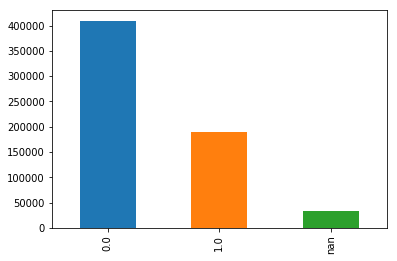

count_families
 1.0     547837
 0.0      50659
 2.0      27771
 3.0       4185
 4.0        939
 5.0        262
 6.0         73
 7.0         19
 8.0          9
 9.0          5
 11.0         1
NaN           1
Name: count_families, dtype: int64


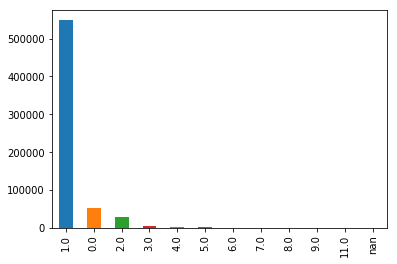

In [15]:
# get distributions of columns containing null
for col in nullCols:
    print col
    #(dfMergedTrain[col].value_counts()/float(len(dfMergedTrain))).sort_values(ascending = False).plot(kind = 'bar')\
    dfMergedTrain[col].value_counts(dropna = False).sort_values(ascending = False).plot(kind = 'bar')
    print dfMergedTrain[col].value_counts(dropna = False).sort_values(ascending = False)
    plt.show()

In [16]:
# engineering missing values in numerical col (count_families)
val = int(round(dfMergedTrain['count_families'].mean()))
dfMergedTrain['count_families'].fillna((val), inplace=True)
dfMergedTrain['count_families'].value_counts(dropna = False).sort_values(ascending = False)

1.0     547838
0.0      50659
2.0      27771
3.0       4185
4.0        939
5.0        262
6.0         73
7.0         19
8.0          9
9.0          5
11.0         1
Name: count_families, dtype: int64

In [17]:
# engineer has_repair_started
dfMergedTrain.has_repair_started = dfMergedTrain.groupby(['condition_post_eq'])['has_repair_started'].apply(lambda x: x.fillna(x.median()))
print dfMergedTrain['has_repair_started'].value_counts(dropna = False).sort_values(ascending = False)

0.0    437978
1.0    193783
Name: has_repair_started, dtype: int64


In [18]:
# ohe
#for var in listCatVars:
dfMergedTrain = pd.get_dummies(dfMergedTrain, columns = listCatVars)
dfMergedTest = pd.get_dummies(dfMergedTest, columns = listCatVars)

In [19]:
def heightLost(df):
    # idea - have a column df[floor_lost] that is df[count_floors_pre_eq] = df[count_floors_post_eq], same for height_ft_post_eq, height_ft_pre_eq
    # dfMergedTrain['floors_lost'] = dfMergedTrain['count_floors_pre_eq'] - dfMergedTrain['count_floors_post_eq']
    print df.shape
    df['height_lost'] = df['height_ft_pre_eq'] - df['height_ft_post_eq']
    df.drop(['count_floors_pre_eq', 'count_floors_post_eq', 'height_ft_pre_eq', 'height_ft_post_eq'], inplace = True, axis = 1)
    print df.shape

In [20]:
heightLost(dfMergedTrain)
heightLost(dfMergedTest)

(631761, 81)
(631761, 78)
(421175, 80)
(421175, 77)


In [21]:
# get incident counts by district_id
dfMergedTrain.groupby(['district_id'])['damage_grade'].value_counts()

district_id  damage_grade
7            Grade 2          794
             Grade 3          686
             Grade 5          593
             Grade 4          458
             Grade 1          183
9            Grade 2          958
             Grade 3          792
             Grade 1          665
             Grade 4          356
             Grade 5          278
10           Grade 3         1864
             Grade 2         1474
             Grade 5         1112
             Grade 4          759
             Grade 1          391
11           Grade 3         3160
             Grade 4         2258
             Grade 5         2224
             Grade 2         2169
             Grade 1          542
12           Grade 3         5539
             Grade 2         5168
             Grade 4         4849
             Grade 1         4758
             Grade 5         3386
13           Grade 3         1971
             Grade 2         1871
             Grade 4         1693
             Grade 5  

# Building Age

18
999     3301
200      243
199        3
196        2
195        1
193        1
192        1
190        7
188        1
185        1
181        1
180       21
178        1
177        1
176        1
175        4
174        3
173        1
172        2
170       10
168        1
167        1
166        1
165        1
164        1
162        2
161        2
160        9
158        1
156        1
       ...  
29      2670
28      7904
27      8176
26      7299
25     33641
24      6822
23      7005
22     17885
21      7261
20     38955
19      6182
18     16146
17     11039
16     12997
15     40598
14     13550
13     12547
12     27996
11      8914
10     30147
9      11364
8      17442
7      17196
6      14614
5      20994
4      16674
3      17079
2      14389
1      12322
0       3071
Name: age_building, Length: 178, dtype: int64
999     2165
200      179
198        1
195        1
192        1
190        4
187        1
180        9
178        1
176        1
175        1
174        1
17

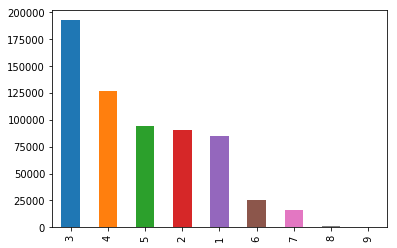

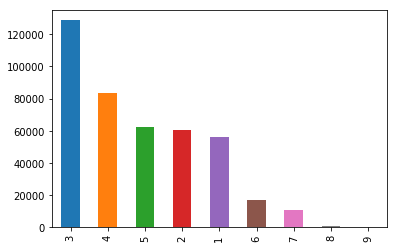

In [22]:
#print (dfMergedTrain['age_building'].value_counts()/float(len(dfMergedTrain['age_building']))).sort_values(ascending=False)
val = int(round(dfMergedTrain['age_building'].median()))
print val
print dfMergedTrain['age_building'].value_counts().sort_index(ascending=False) # 3301 buildings with age 999 (unknown?)
print dfMergedTest['age_building'].value_counts().sort_index(ascending=False)
# print dfMergedTrain['age_building'].isnull().sum()
dfMergedTrain.loc[dfMergedTrain['age_building'] == 999, 'age_building'] = val
dfMergedTest.loc[dfMergedTest['age_building'] == 999, 'age_building'] = val
#print dfMergedTrain['age_building'].value_counts().sort_index(ascending=False)

dfMergedTrain['age'] = pd.cut(dfMergedTrain.age_building, bins=[-1,5,10,20,30, 50, 75, 100, 140, 250], labels=range(1,10))
dfMergedTrain['age'].value_counts().plot(kind='bar')
plt.show()
dfMergedTest['age'] = pd.cut(dfMergedTest.age_building, bins=[-1,5,10,20,30, 50, 75, 100, 140, 250], labels=range(1,10))
dfMergedTest['age'].value_counts().plot(kind='bar')
plt.show()

# Plinth Area
Measurements range from 70 sq ft to 5220

5220       1
5160       1
5000       4
4995       1
4901       1
4890       1
4873       1
4802       1
4800       1
4795       1
4788       1
4738       1
4701       1
4606       1
4600       1
4570       1
4560       1
4557       1
4556       1
4520       1
4502       1
4500       7
4482       1
4475       1
4473       1
4470       1
4465       1
4452       1
4449       1
4445       1
        ... 
100     1022
99       296
98        39
97         4
96       183
95        61
94        30
93         3
92        28
91        55
90       200
89         4
88        33
87         5
86        32
85        71
84        48
82         7
81        62
80       217
79         8
78        29
77        24
76         3
75        70
74         2
73         8
72        43
71         1
70        82
Name: plinth_area_sq_ft, Length: 2069, dtype: int64
300     23211
450     19163
400     17446
350     16872
360     12224
250     11799
280     11006
200     10411
600     10367
320     10158
500      9850
4

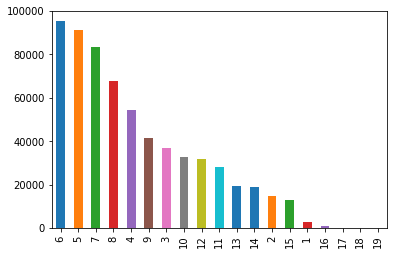

AxesSubplot(0.125,0.125;0.775x0.755)


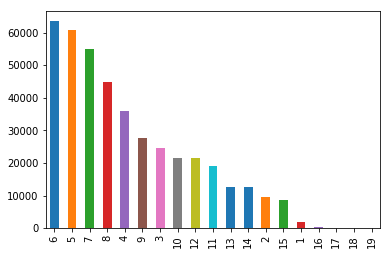

In [23]:
print dfMergedTrain['plinth_area_sq_ft'].value_counts().sort_index(ascending=False)
print dfMergedTrain['plinth_area_sq_ft'].value_counts().sort_values(ascending=False)

print dfMergedTest['plinth_area_sq_ft'].value_counts().sort_index(ascending=False)
print dfMergedTest['plinth_area_sq_ft'].value_counts().sort_values(ascending=False)
# print dfMergedTrain.groupby(['damage_grade'])['plinth_area_sq_ft'].mean()

dfMergedTrain['plinth'] = pd.cut(dfMergedTrain.plinth_area_sq_ft, bins=[-1,100,150,200, 250,300, 350, 400, 450, 500, 550, 600, 700, 800, 1000, 2000, 3000, 4000, 5000, 6000], labels=range(1,20))
dfMergedTest['plinth'] = pd.cut(dfMergedTest.plinth_area_sq_ft, bins=[-1,100,150,200, 250,300, 350, 400, 450, 500, 550, 600, 700, 800, 1000, 2000, 3000, 4000, 5000, 6000], labels=range(1,20))


print dfMergedTrain['plinth'].value_counts().plot(kind='bar')
plt.show()
print dfMergedTest['plinth'].value_counts().plot(kind='bar')
# dfMergedTrain.head()

In [24]:
# get correlations
corrmat = dfMergedTrain.corr().abs().unstack()
corrmat = corrmat[corrmat > .8]
corrmat = corrmat[corrmat < 1]
print corrmat

district_id                            vdcmun_id                                0.999694
vdcmun_id                              district_id                              0.999694
land_surface_condition_Flat            land_surface_condition_Moderate slope    0.884128
land_surface_condition_Moderate slope  land_surface_condition_Flat              0.884128
roof_type_Bamboo/Timber-Heavy roof     roof_type_Bamboo/Timber-Light roof       0.851785
roof_type_Bamboo/Timber-Light roof     roof_type_Bamboo/Timber-Heavy roof       0.851785
position_Attached-1 side               position_Not attached                    0.824188
position_Not attached                  position_Attached-1 side                 0.824188
dtype: float64


In [25]:
# drop vdcmun_id col, since municipality highly correlated to district
target = dfMergedTrain['damage_grade']
dfMergedTrain.drop(['vdcmun_id', 'building_id', 'damage_grade'], inplace = True, axis = 1)


dfMergedTest.drop(['vdcmun_id', 'building_id'], inplace = True, axis = 1)

In [26]:
dfMergedTrain['cnt_fam'] = pd.cut(dfMergedTrain.count_families, bins=[-1,.9,1.9,2.9, 100], labels=range(1,5))
dfMergedTest['cnt_fam'] = pd.cut(dfMergedTest.count_families, bins=[-1,.9,1.9,2.9, 100], labels=range(1,5))
dfMergedTrain.drop(['count_families'], inplace = True, axis = 1)
dfMergedTest.drop(['count_families'], inplace = True, axis = 1)

In [27]:
dfMergedTrain.drop(['age_building'], inplace = True, axis = 1)
dfMergedTrain.drop(['plinth_area_sq_ft'], inplace = True, axis = 1)

dfMergedTest.drop(['age_building'], inplace = True, axis = 1)
dfMergedTest.drop(['plinth_area_sq_ft'], inplace = True, axis = 1)

print dfMergedTrain.shape
print dfMergedTest.shape

(631761, 75)
(421175, 75)


In [31]:
# print dfMergedTrain.shape
# Create and fit selector
for ks in [10, 40, 60, 75]:
    print ks , "*******************************************************************************************************"
    selector = SelectKBest(f_classif, k=ks)
    selector.fit(dfMergedTrain, target)
    # Get idxs of columns to keep
    idxs_selected = selector.get_support(indices=False)
    print idxs_selected
    # Create new dataframe with only desired columns, or overwrite existing
    features = selector.transform(dfMergedTrain)
    print features.shape

    # used for evaluating model params with GridSearchCV
    k_range = range(1, 20)
    weight_options = ['uniform', 'distance']
    #mD = range(4, 15)
    mD = range(4, 20)
    #nEst = range(5, 17)
    nEst = range(5, 20)
    split = ['best', 'random']
    #min_split =range(2, 5)
    min_split =range(5, 20)
    class_w = [{0:.3, 1:.7}, {0:.2, 1:.8}, None]
    priors = [None]
    hiddenUnits = range(2,15)
    #hiddenUnits = [x for x in it.product((10,20,30,40,50,100),repeat=3)]
    #hiddenUnits = [x for x in it.product((2, 4, 6),repeat=2)]
    #activation = ["identity", "logistic", "tanh"]
    activation = ["identity"]
    #solver = ['lbfgs', 'adam', 'sgd']
    solver = ['adam']
    max_iter = [300]
    max = 0

#     # rand forest
#     param_grid = dict(max_depth=mD, min_samples_split=min_split, n_estimators = nEst)
#     grid = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv = 10, scoring = 'accuracy', verbose = 4)


    # nn
    param_grid = dict(solver=solver, activation = activation, max_iter=max_iter, hidden_layer_sizes = hiddenUnits)
    grid = GridSearchCV(MLPClassifier(random_state = 0), param_grid, cv = 10, scoring = 'accuracy', verbose = 5)

    # bayes
    # param_grid = {}
    # grid = GridSearchCV(GaussianNB(), param_grid, cv = 10, scoring = 'accuracy', verbose = 10)

    grid.fit(features, target)
    print grid.best_score_
    print grid.best_params_
    if (grid.best_score_ > max):
        max = grid.best_score_
    print max

10 *******************************************************************************************************
[False False False False False False False False False False False False
 False False False False False False False False  True  True False False
 False False False False False False  True False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
  True  True False  True  True False  True False False False False  True
 False False False]
(631761L, 10L)
Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.689084808003, total=  10.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.3s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.69315267973, total=  10.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.8s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.689290575833, total=  10.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.0s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.688926525056, total=  10.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.5s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.690642015955, total=  10.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.690035615354, total=  11.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.689133359715, total=  11.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.687170557974, total=  11.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.68980909868, total=  11.9s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.690632222117, total=   8.0s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.691091271726, total=  10.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.692392921587, total=   9.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.696460793314, total=  10.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.692931083605, total=   9.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_laye

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.69267783089, total=   7.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.691348254139, total=   7.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.691385969355, total=   7.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.693802928374, total=   7.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.69180846854, total=   8.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hid

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 20.8min finished


0.6922681203809669
{'activation': 'identity', 'max_iter': 300, 'solver': 'adam', 'hidden_layer_sizes': 13}
0.6922681203809669
40 *******************************************************************************************************
[ True  True False False False  True  True  True False False  True  True
  True False  True  True  True  True False  True  True  True  True False
  True False False False  True  True  True False  True  True  True  True
 False  True False  True False  True  True  True False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True False False False  True  True
  True  True False]
(631761L, 40L)
Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.701225110007, total=  21.5s
[CV] activation=identity, max_iter=300, solv

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.1s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.703915920099, total=  17.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.0s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.699214916585, total=  16.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.0s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.699499825889, total=  14.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.702276180828, total=  16.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.703426988524, total=  16.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.701115947764, total=  14.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.696113969133, total=  21.8s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.69974989711, total=  19.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.701902681483, total=  11.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.701902681483, total=  11.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.70314033366, total=  16.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.707208205388, total=  17.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.702602171642, total=  14.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.70385260692, total=  19.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.700956028997, total=  17.8s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.703067620615, total=  19.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.704819944598, total=  18.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.703363672339, total=  18.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hi

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 37.5min finished


0.7029731179987369
{'activation': 'identity', 'max_iter': 300, 'solver': 'adam', 'hidden_layer_sizes': 3}
0.7029731179987369
60 *******************************************************************************************************
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True False  True  True  True  True  True  True  True  True
 False  True False  True False  True  True  True  True  True  True  True
  True False False False  True False False  True  True False False False
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True]
(631761L, 60L)
Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.700196270854, total=  15.3s
[CV] activation=identity, max_iter=300, solve

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.705292981734, total=  13.9s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.7s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.700987685587, total=  14.9s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.4s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.699784735193, total=  14.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.704397239458, total=  15.0s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.70228729719, total=  13.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.702398100514, total=  13.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.697491096161, total=  13.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.700731313515, total=  15.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.704467027575, total=  16.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.702947415076, total=  16.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.703456899554, total=  14.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.70782550888, total=  13.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.705261325145, total=  13.4s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.702617999937, total=  22.8s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.698629269682, total=  22.8s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.705774344688, total=  22.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.705231499802, total=  19.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.703648595172, total=  19.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, h

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 38.7min finished


0.7039703305522184
{'activation': 'identity', 'max_iter': 300, 'solver': 'adam', 'hidden_layer_sizes': 7}
0.7039703305522184
75 *******************************************************************************************************
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
(631761L, 75L)
Fitting 10 folds for each of 13 candidates, totalling 130 fits
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.700639463104, total=  26.2s
[CV] activation=identity, max_iter=300, solve

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.9s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.705989426699, total=  29.0s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.7s remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.701209281712, total=  29.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.701098483649, total=  29.2s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s


[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.703194250981, total=  29.0s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.702809655718, total=  29.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.701669964385, total=  28.0s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.696952908587, total=  29.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2, score=0.701348656093, total=  25.7s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=2 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_laye

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.703501440466, total=  14.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=6, score=0.701617754139, total=  13.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.703472727848, total=  24.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.708110418184, total=  24.5s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7, score=0.702475545285, total=  25.9s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=7 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_laye

[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.704596536769, total=  15.1s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.70314033366, total=  21.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.705188679245, total=  19.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.704946576969, total=  19.3s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11, score=0.703822714681, total=  30.6s
[CV] activation=identity, max_iter=300, solver=adam, hidden_layer_sizes=11 
[CV]  activation=identity, max_iter=300, solver=adam, hi

[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 47.2min finished


0.7039829935687705
{'activation': 'identity', 'max_iter': 300, 'solver': 'adam', 'hidden_layer_sizes': 4}
0.7039829935687705


In [46]:
# # used for evaluating model params with GridSearchCV
# k_range = range(1, 20)
# weight_options = ['uniform', 'distance']
# #mD = range(4, 15)
# mD = range(7, 15)
# #nEst = range(5, 17)
# nEst = range(7, 15)
# split = ['best', 'random']
# #min_split =range(2, 5)
# min_split =range(8, 15)
# class_w = [{0:.3, 1:.7}, {0:.2, 1:.8}, None]
# priors = [None]
# #hiddenUnits = range(1,5)
# #hiddenUnits = [x for x in it.product((10,20,30,40,50,100),repeat=3)]
# hiddenUnits = [x for x in it.product((2, 4, 6),repeat=3)]
# activation = ["identity", "logistic", "tanh", 'relu']
# solver = ['lbfgs', 'adam', 'sgd']
# #max_iter = [300, 500, 700]
# max = 0

# # rand forest
# param_grid = dict(max_depth=mD, min_samples_split=min_split, n_estimators = nEst)
# grid = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv = 10, scoring = 'accuracy', verbose = 8)


# # nn
# # param_grid = dict(solver=solver, activation = activation, max_iter=max_iter, hidden_layer_sizes = hiddenUnits)
# # grid = GridSearchCV(MLPClassifier(random_state = 0), param_grid, cv = 10, scoring = 'accuracy', verbose = 10)

# # bayes
# param_grid = {}
# #grid = GridSearchCV(GaussianNB(), param_grid, cv = 10, scoring = 'accuracy', verbose = 10)
# grid = GridSearchCV(GaussianProcessClassifier(.5*RBF(1.0)), param_grid, cv = 5, scoring = 'accuracy', verbose = 10)

# grid.fit(dfMergedTrain, target)
# print grid.best_score_
# print grid.best_params_
# if (grid.best_score_ > max):
#     max = grid.best_score_
# print max

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


MemoryError: 

In [39]:
selector = SelectKBest(f_classif, k=30)
selector.fit(dfMergedTrain, target)
# Get idxs of columns to keep
idxs_selected = selector.get_support(indices=False)
print idxs_selected
# Create new dataframe with only desired columns, or overwrite existing
features = selector.transform(dfMergedTrain)

# clf = RandomForestClassifier(min_samples_split=9, n_estimators=9, max_depth=10, random_state=0)#.fit(dfMergedTrain, target)
# scores = cross_val_score(clf, features, target, cv=10)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) #Accuracy: 0.70 (+/- 0.01)

# clf = DecisionTreeClassifier(min_samples_split=2, max_depth=None, random_state=0)#.fit(dfMergedTrain, target)
# scores = cross_val_score(clf, target, cv=10)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) #Accuracy: 0.70 (+/- 0.01)

# clf = MLPClassifier(activation='identity', max_iter=700, solver='adam', hidden_layer_sizes=(2), random_state=0)#.fit(dfMergedTrain, target)
# scores = cross_val_score(clf, dfMergedTrain, target, cv=10)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) #Accuracy: 0.70 (+/- 0.00)

[False False False False False  True False  True False False False  True
 False False  True  True False False False False  True  True  True False
  True False False False  True  True  True False  True False  True  True
 False  True False  True False  True  True  True False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True False False False False  True
  True  True False]
Accuracy: 0.70 (+/- 0.00)


In [40]:
# clf = RandomForestClassifier(min_samples_split=9, n_estimators=9, max_depth=10, random_state=0).fit(dfMergedTrain, target) # 65%
clf = MLPClassifier(activation='identity', max_iter=700, solver='adam', hidden_layer_sizes=(2, 4), random_state=0).fit(dfMergedTrain, target)
predArray = clf.predict(dfMergedTest)
#updatedTestArray = array(dfTest.iloc[:, :])
with open("output.csv","w") as f:
    f.write("building_id,damage_grade\n")
    for x in range(0, len(predArray)):
        predVal = predArray[x]
        # f.write(str(dfMergedTest.iloc[x,1]) + "," + str(predVal)[1:-1] +"\n")
        f.write(str(buildingId[x]) + "," + str(predVal) +"\n")
        # f.write(str(buildingId[x]) + "," + str(1) +"\n")

NameError: name 'buildingId' is not defined

In [ ]:
# cols = ['district_id', 'count_families']
# for c in cols:
#     x = dfMergedTrain[c].value_counts().sort_index()
#     print x#(dfMergedTrain[c].value_counts() / float(len(dfMergedTrain))).sort_index()
#     x.plot(kind='bar')
#     #(dfMergedTrain[c].value_counts() / float(len(dfMergedTrain))).sort_index().plot(kind='bar')
#     plt.show()

In [ ]:
# x = dfMergedTrain['cnt_fam'].value_counts().sort_index()
# print x#(dfMergedTrain[c].value_counts() / float(len(dfMergedTrain))).sort_index()
# x.plot(kind='bar')